In [11]:
import numpy as np
import pandas as pd
import json
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, GPT2Config
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from transformers import Trainer, TrainingArguments
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score, classification_report
from sklearn.preprocessing import label_binarize
import os
from sklearn.utils import resample
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
# Read JSONL files
def read_jsonl(file_path):
    records = []
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            records.append(json.loads(line))
    return pd.DataFrame(records)

# Read datasets
train_df = read_jsonl('../input/scicite/train.jsonl')
dev_df = read_jsonl('../input/scicite/dev.jsonl')
test_df = read_jsonl('../input/scicite/test.jsonl')

In [13]:
train_label_counts = train_df['label'].value_counts()
print("Training Set Label Distribution:")
print(train_label_counts)

Training Set Label Distribution:
label
background    4840
method        2294
result        1109
Name: count, dtype: int64


In [14]:
dev_label_counts = dev_df['label'].value_counts()
print("\nValidation Set Label Distribution:")
print(dev_label_counts)


Validation Set Label Distribution:
label
background    538
method        255
result        123
Name: count, dtype: int64


In [15]:
test_label_counts = test_df['label'].value_counts()
print("\nTest Set Label Distribution:")
print(test_label_counts)


Test Set Label Distribution:
label
background    997
method        605
result        259
Name: count, dtype: int64


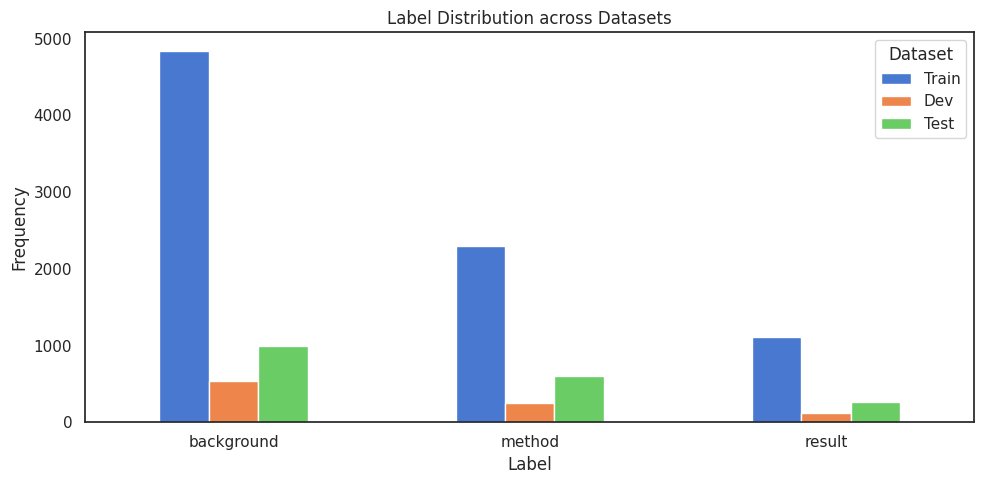

In [17]:
summary_df = pd.DataFrame({
    'Train': train_label_counts,
    'Dev': dev_label_counts,
    'Test': test_label_counts
})
sns.set(style="white", palette="muted", color_codes=True)
summary_df.plot(kind='bar', figsize=(10, 5))
plt.title('Label Distribution across Datasets')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(rotation=0) 
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

In [3]:
# Define the mapping of labels to integers
label_to_int = {
    'background': 0,
    'method': 1,
    'result': 2
}

# Convert labels to integers
train_df['label'] = train_df['label'].map(label_to_int)
dev_df['label'] = dev_df['label'].map(label_to_int)
test_df['label'] = test_df['label'].map(label_to_int)

In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def advanced_text_preprocessing(text):
    # Tokenize
    tokens = word_tokenize(text)
    # Removal of stop words and non-alphabetic characters and word formation reduction
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(tokens)

In [9]:
def preprocess(df):
    # Combine texts
    df['text'] = df['string'].astype(str) + ' [SEP] ' + df['sectionName'].astype(str).fillna('') + ' [SEP] ' + df['isKeyCitation'].astype(str)
    # Apply text preprocessing
    df['text'] = df['text'].apply(advanced_text_preprocessing)
    
    return df

In [10]:
def oversample(df):    
    df_background = df[df['label'] == 0]
    df_method = df[df['label'] == 1]
    df_result = df[df['label'] == 2]
    # oversample result label
    df_result_oversampled = resample(df_result, replace=True, n_samples=len(df_background), random_state=123)
    
    df_oversampled = pd.concat([df_background, df_method, df_result_oversampled])
    df_oversampled = df_oversampled.sample(frac=1).reset_index(drop=True)
    return df_oversampled

In [11]:
nltk.download('wordnet2022')
! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet

[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


In [12]:
train_df = preprocess(train_df)
dev_df = preprocess(dev_df)
test_df = preprocess(test_df)

train_df = oversample(train_df)
dev_df = oversample(dev_df)

In [4]:
# Instantiate the configuration for model
configuration = GPT2Config()

# Set up tokenizer and  pad token
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Instantiate the model
model = GPT2ForSequenceClassification(configuration).from_pretrained('gpt2', num_labels=3)

# Set the pad token of the model's configuration
model.config.pad_token_id = model.config.eos_token_id

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# if torch.cuda.device_count() > 1:
#     print(f"Use {torch.cuda.device_count()} GPUs")
#     model = nn.DataParallel(model)

Use 2 GPUs


In [5]:
# Encode datasets
class CitationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Prepare datasets
def encode_data(tokenizer, texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
    return CitationDataset(encodings, labels)

train_dataset = encode_data(tokenizer, train_df['string'].tolist(), train_df['label'].tolist())
dev_dataset = encode_data(tokenizer, dev_df['string'].tolist(), dev_df['label'].tolist())
test_dataset = encode_data(tokenizer, test_df['string'].tolist(), test_df['label'].tolist())

In [6]:
try:
    from accelerate import Accelerator
    print("Accelerate is installed and can be imported.")
except ImportError as e:
    print("Accelerate is not installed or there's an issue with importing it.")

Accelerate is installed and can be imported.


In [7]:
# Define training parameters
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [8]:
# Set environment variable for PyTorch
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = "max_split_size_mb:50"

In [9]:
# Train
trainer.train()

Step,Training Loss
50,4.611800
100,1.266200
150,0.732500
200,0.582400
250,0.502200
300,0.486800
350,0.402900
400,0.402900
450,0.403500
500,0.410200


TrainOutput(global_step=1285, training_loss=0.5230497623695938, metrics={'train_runtime': 2445.9071, 'train_samples_per_second': 16.851, 'train_steps_per_second': 0.525, 'total_flos': 1.07393934163968e+16, 'train_loss': 0.5230497623695938, 'epoch': 4.99})

In [10]:
model_save_path = '/kaggle/working/my_model.pth'

# save model
torch.save(model.state_dict(), model_save_path)

In [11]:
# Predict
predictions = trainer.predict(test_dataset)

# Extract predicted results and true labels
preds = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids
n_classes = np.max(true_labels) + 1
true_labels_binary = label_binarize(true_labels, classes=range(n_classes))

In [12]:
# Compute f1 score, accuracy, precision, recall and auc
f1 = f1_score(true_labels, preds, average='weighted')
accuracy = accuracy_score(true_labels, preds)
precision = precision_score(true_labels, preds, average='weighted')
recall = recall_score(true_labels, preds, average='weighted')
auc = roc_auc_score(true_labels_binary, predictions.predictions, multi_class='ovr')

print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'AUC (One-vs-Rest): {auc}')

F1 Score: 0.8483539149192114
Accuracy: 0.84631918323482
Precision: 0.8560910764588215
Recall: 0.84631918323482
AUC (One-vs-Rest): 0.9487626868307276


In [13]:
print('classification_report\n',classification_report(true_labels, preds))

classification_report
               precision    recall  f1-score   support

           0       0.89      0.84      0.87       997
           1       0.87      0.83      0.85       605
           2       0.68      0.90      0.77       259

    accuracy                           0.85      1861
   macro avg       0.81      0.86      0.83      1861
weighted avg       0.86      0.85      0.85      1861



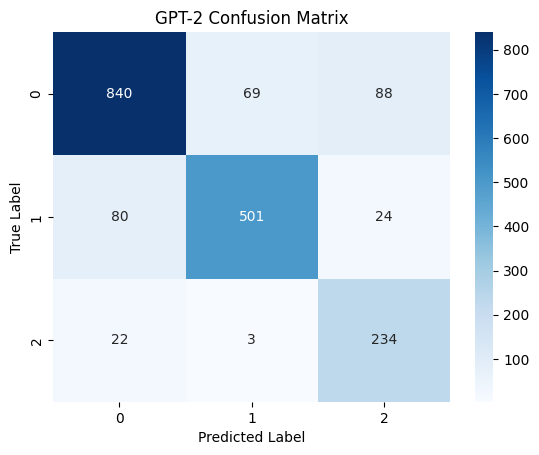

In [19]:
cm = confusion_matrix(true_labels, preds)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('GPT-2 Confusion Matrix')
plt.show()